# Continuous RL - Reinforce

In [1]:
import random
import os
import numpy as np
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn as nn
from torch.optim import AdamW
from tqdm import tqdm
from utils import plot_cost_to_go , plot_max_q , test_agent , plot_stats , seed_everything , plot_action_probs , test_policy_network
from parallel_env import ParallelEnv , ParallelWrapper
%matplotlib notebook

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Ali\Documents\RLwithPhil\code\parallel_env.py:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool: ctypes.c_bool}


In [2]:
env = gym.make('CartPole-v0')

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"state dim: {state_dims}, action dim: {num_actions}")

state dim: 4, action dim: 2


In [4]:
## Parallelize Environment
num_envs = int(os.cpu_count() / 2)
print(f"Max num_envs : {num_envs}")

Max num_envs : 8


In [5]:
def create_env(env_name , seed):
    env = gym.make(env_name)
    seed_everything(env , seed = seed)
    return env

In [6]:
env_fns = [lambda: create_env('CartPole-v0',rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [7]:
parallel_env.reset() # num_envs x 4 states

array([[ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928],
       [ 0.01250955,  0.03972138,  0.02756857, -0.02747928]],
      dtype=float32)

In [8]:
class PreprocessEnv(ParallelWrapper): ## to be able to work with pyTorch library
    def __init__(self , parallel_env ):
        ParallelWrapper.__init__(self, parallel_env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self , actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
        
    def step_wait(self):
        next_state , reward , done , info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state , reward , done , info

In [9]:
parallel_env = PreprocessEnv(parallel_env )

In [10]:
parallel_env.reset()

tensor([[-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321],
        [-0.0200,  0.0374, -0.0495,  0.0321]])

In [11]:
parallel_env.step(torch.zeros(num_envs,1 , dtype = torch.int32))

(tensor([[-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088],
         [-0.0192, -0.1570, -0.0488,  0.3088]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]]),
 ({}, {}, {}, {}, {}, {}, {}, {}))

In [12]:
policy = nn.Sequential(
    nn.Linear(state_dims , 128),
    nn.ReLU(),
    nn.Linear(128 , 64),
    nn.ReLU(),
    nn.Linear(64,num_actions),
    nn.Softmax(dim=-1))

policy

Sequential(
  (0): Linear(in_features=4, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
  (5): Softmax(dim=-1)
)

In [13]:
def reinforce(policy , episodes , alpha=1e-4 , gamma = 0.99 , beta=1e-2 ):
    optim = AdamW(policy.parameters() , lr = alpha)
    stats = {'Performance' : [] , 'Returns' : []}
    
    for episode in tqdm(range(1 , episodes+1) ) :
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs , 1),dtype=torch.bool)
        transitions=[]
        ep_return= torch.zeros((num_envs , 1))
        
        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state , reward , done , _ = parallel_env.step(action)
            transitions.append([state , action , torch.logical_not(done_b) * reward])
            ep_return += reward
            done_b |= done
            state = next_state
            
        G = torch.zeros((num_envs ,1))
        
        for t , (state_t , action_t , reward_t) in reversed(list(enumerate(transitions))):
            G = reward_t + gamma*G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather( 1 ,action_t)
            
            entropy_t = - torch.sum(probs_t * log_probs_t , dim=1 , keepdim=True)
            gamma_t = gamma ** t
            
            pg_loss = - (gamma_t * G * action_log_prob_t)
            total_loss_t = (pg_loss - beta * entropy_t).mean()
            
            policy.zero_grad()
            total_loss_t.backward()
            optim.step()
        stats['Performance'].append(total_loss_t.item())
        stats['Returns'].append(ep_return.mean())
        
    return stats       

In [14]:
parallel_env.reset()
stats = reinforce(policy , 500)

100%|█████████████████████████████████████████████████████████████████████████| 500/500 [02:14<00:00,  3.73it/s]


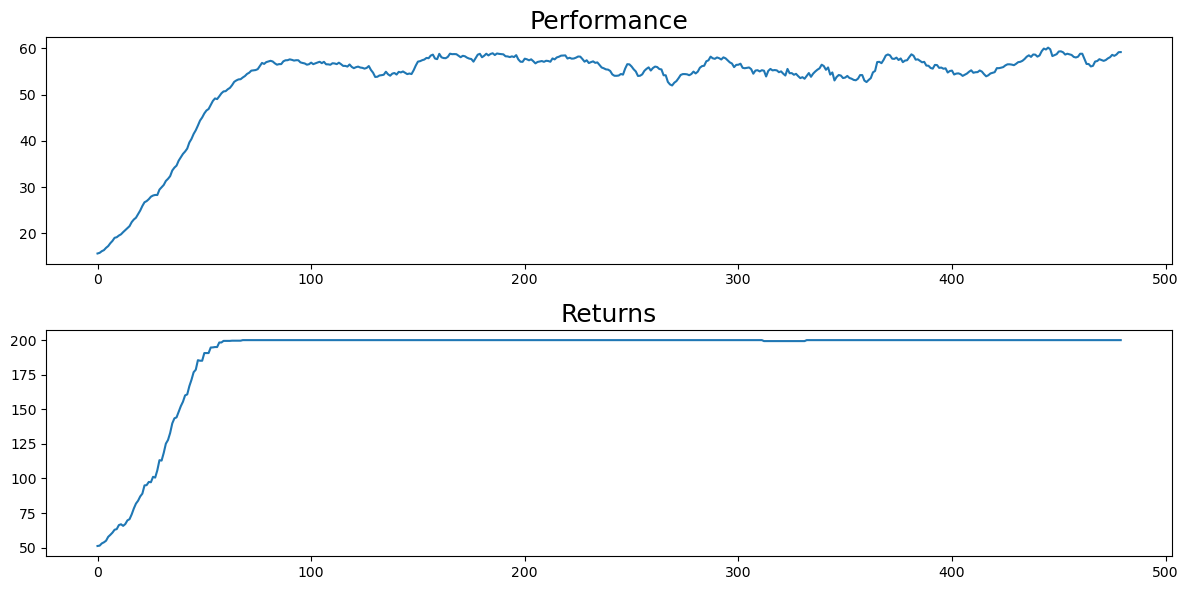

In [17]:
plot_stats(stats)

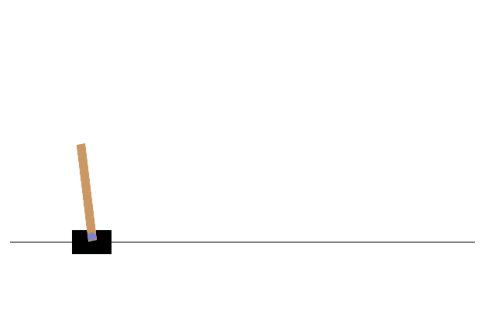

In [18]:
%matplotlib inline
test_policy_network(env , policy , 2)